

# BFS:MeerKAT Aggregation

This notebook is for aggregating the results of the Bursts from Space: MeerKAT.
We have removed all personal data from volunteers and use the anonymous, aggregated data. If you want to investigate the aspects of citizen science in more detail, please feel free to get in touch.


The first few cells are processing the data, combining a few tables together and writing a few functions to calculate
different statistics for each light curve. 
The later cells deal with plots from the paper.

I've not made any attempts at beautifying the code, so please get in touch if something isn't clear!

In [6]:
folder = '/Users/andersson/Documents/BfS MKT/BfS-MKT-Analysis/'

In [7]:
%matplotlib inline 
#notebook
import pandas as pd

#from panoptes_aggregation.csv_utils import unjson_dataframe
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np

import sys

import ast
import glob

import astropy.units as u
from astropy.coordinates import SkyCoord

import time

import pyshorteners


#sys.path.append(folder + "data-digging/scripts_GeneralPython")

In [8]:
# read-in and calculating simple vote fractions.
data = pd.read_csv('ProjectData/question_reducer_reductions.csv')
data = data.fillna(0)
subjectdata = pd.read_csv('ProjectData/bursts-from-space-meerkat-subjects.csv')
subjectdata.fillna(0)
print(len(data), 'sources classified')



data['Sum'] = (data['data.transient-variable']+data['data.stable']+data['data.extended-blob']
              +data['data.unsure']+data['data.artefact']).fillna(0)
data['transFrac'] = data['data.transient-variable'] / data.Sum
data['stableFrac'] = data['data.stable'] / data.Sum
data['extendFrac'] = data['data.extended-blob'] / data.Sum
data['unsureFrac'] = data['data.unsure']/data.Sum
data['arteFrac']  =  data['data.artefact']/data.Sum
data['T+U'] = (data['data.unsure'] + data['data.transient-variable'])/data.Sum

# this merges the reduced classifications with the original subject data
# allowing us to instantly check the data and metadata (including downloading files from online) for a given subject
data = pd.merge(data, subjectdata, how='inner', on=['subject_id'])
data = pd.concat([data,pd.DataFrame([ast.literal_eval(row) for row in data['metadata']])],axis=1)
data = pd.concat([data,pd.DataFrame([ast.literal_eval(row) for row in data['locations']])],axis=1)
data = data.rename(columns={"0": "LCurl", "1": "Imageurl"})

#here we make a column called field, constructed by stripping name of each LC file. Based on the field names given to
#TraP. for GX339-4 the DB was just called 'andersson' by default, hence the lambda expression to change it
data = pd.concat([
    data['LC'].str.split('_',expand=True)[3].apply(lambda x: 'GX339'if x == 'anderssontrapLC.png' else x).str.split('Tr',expand=True)[0]
                  , data],axis=1)
data = data.rename(columns={0:'Field'})
print(len(data), 'sources classified')

pd.set_option('display.max_columns', 1000)

8874 sources classified
8874 sources classified


In [9]:
#Here we're adding the TraP statistics (eta, V, fluxes etc) to our classification data
# making a slightly massive table.

sdl = []
for i, file in enumerate(glob.iglob(folder + 'TraPData/TraPSourceStats/*', recursive=True)):
    f = file.split('/')[-1].split('Source')[0]
    sourcedata = pd.read_csv(file)
    sourcedata['Field'] = f
    sdl.append(sourcedata)

SourceData = pd.concat(sdl)  
data = data.astype({'runcat':'int64'})
data = data.astype({'medianFlux(mJy)':'float64'})

data = pd.merge(data, SourceData, how='left', on=['Field','runcat'])

In [10]:
# here is where we combine expert labels to the citSci votes to produce our final variable sample. To do this we took
#all sources above a transFrac of 0.4, eyeballed them and wrote booleans, with notes
#this obviously is somewhat subjective and i've revised the list slightly over time. Happy to discuss!
T=0.4
MajorTrans = data[data['transFrac']>= T]
print(len(MajorTrans))

ELs = pd.read_csv('0.4TExpertLabels.csv')
ELT = pd.merge(MajorTrans, ELs, how='inner', on=['runcat','Field'])

data = pd.merge(data,ELs, how='left',on=['runcat','Field']).fillna(value=0)
print(len(data[data['t/v']==1]))



381
168


In [11]:
#here we define some functions for light curve statistics:
# please note that the first three are from Laura Driessen's code: 
# https://github.com/AstroLaura/MeerKAT_LightCurve_Analysis
def madulation_parameter(data):
    '''
    Use the median and mad to make a modulation-type parameter.

    Args:
    data (array): the 1D array
                  of data that you
                  want to find the
                  MAD parameter of
    Returns:
    (madvalue, madlocation)
    The value of the MAD parameter
    and the index of the epoch
    of the MAD parameter
    '''
    me = np.nanmedian(data)
    ma = np.nanmedian(np.absolute(data-np.nanmedian(data)))

    
    data_ = np.copy(data)
    
    shifted_data = np.abs(data_ - me)
    divided_by_mad = shifted_data/ma
    
    try:
        madvalue = np.nanmax(divided_by_mad)
        madlocation = np.nanargmax(divided_by_mad)
    except ValueError:
        madvalue = np.nan
        madlocation = np.nan
    
    return madvalue, madlocation

def chi2_parameter(data, uncertainties):
    '''
    Calculate the chi2 variability parameter for a set of points.
    
    A description of the variability parameter
    can be found here:
    https://tkp.readthedocs.io/en/r3.0/devref/
    database/schema.html#appendices
    
    Args:
    data (array): a 1D row array of data points
    uncertainties (array): the 1D array of uncertainties
                           that corresponds to the data array
    
    Returns:
    A float that is the value of the variability
    parameter for the data array
    '''
    weights = 1./(uncertainties**2.)
    
    if len(data[~np.isnan(data)]) < 2:
        p1 = 1
    else:
        p1 = len(data[~np.isnan(data)])/(len(data[~np.isnan(data)])-1.)
    p2 = np.nanmean(weights*(data**2.))
    p3 = ((np.nanmean(weights*data))**2.)/(np.nanmean(weights))
    
    return p1 * (p2 - p3)
def modulation_parameter(data):
    '''
    Calculate the modulation parameter for a set of points.
    
    A description of the modulation parameter
    can be found here:
    https://tkp.readthedocs.io/en/r3.0/devref/
    database/schema.html#appendices
    
    Args:
    data (array): a 1D row array of data points
    
    Returns:
    A float that is the value of the modulation
    parameter for the data array
    '''

    p1 = 1./np.nanmean(data)
    if len(data[~np.isnan(data)]) <2:
        p2 = 1
    else:
        p2 = len(data[~np.isnan(data)])/(len(data[~np.isnan(data)])-1)
    p3 = np.nanmean(data**2.) - (np.nanmean(data))**2.
    
    return p1 * np.sqrt(p2*p3)

phaseCentres = {'GX339': SkyCoord(255.70566666667, -48.789666666667,unit=(u.deg, u.deg)),
                'GRS1915': SkyCoord(288.798125, 10.9416111111111,unit=(u.deg, u.deg)),
                'J1848G': SkyCoord(282.2075416667, -1.49166666666667,unit=(u.deg, u.deg)),
                'MAXIJ1803': SkyCoord(270.761625, -29.8263055555556,unit=(u.deg, u.deg)),
                'SAXJ1808': SkyCoord(272.11475, -36.9789722222222,unit=(u.deg, u.deg)),
                '4U1543': SkyCoord(236.7845000000, -47.67361111111,unit=(u.deg, u.deg)),
                'EXO1846': SkyCoord(282.3207916666666, -3.06536111111111,unit=(u.deg, u.deg)),
                'H1743': SkyCoord(266.565, -32.2335833333333,unit=(u.deg, u.deg)),
                'J1858': SkyCoord(284.6456667, -8.23788888888889,unit=(u.deg, u.deg)),
                'MAXIJ1348': SkyCoord(207.05304166667, -63.27411111111,unit=(u.deg, u.deg)),
                'MAXIJ1820': SkyCoord(275.0914166666666, 7.18533333333333,unit=(u.deg, u.deg))
}
def dist_phase_centre(field,RA,Dec,PhaseCentres):
    objCoord = SkyCoord(RA,Dec,unit=(u.deg, u.deg))
    pc = phaseCentres[field]
    return pc.separation(objCoord).arcminute


KnownVs = {'GX339':[10165,10181,10204,10224,10233,10235,10239,10209,10280,10293,
                    10266,10264,10317,10736,10334,10484,10486,10449,
                    10496,10559,10609,10657,10663],
           'GRS1915': [3169], 'J1848G': [94, 229,266],
          'MAXIJ1803':[309],'SAXJ1808':[601], '4U1543':[853, 329],
          'EXO1846':[282, 89],'H1743':[2224,2138,2139,1932],
          'J1858':[2323], 'MAXIJ1348':[183,431,504],'MAXIJ1820':[229, 583, 356, 416, 211, 447, 1166, 1100]}
def KnownLabels(EL,KnownVs,field,runcat):
    if runcat in KnownVs[field]:
        return 1
    else:
        return 0
    
def FractionalVariability(data):
    return (max(data)-min(data))/np.median(data)
    


In [12]:
#this cell takes a few mins to run: it accesses all light curves, adds some stats calculated from each to the data df
LCList = []

start_time = time.time()
for i, file in enumerate(glob.iglob(folder +'TraPData/AllLightCurves/*/*',recursive=True)):
    LC = pd.read_csv(file)
    f = file.split('/')[-1].split('_')[-2].rstrip('TraPDB')
    if 'dec' in f:
        f = 'GX339'
    runcat = int(file.split('/')[-1].split('_')[0])
    #LC['Field'] = f
    #LC['runcat'] = runcat
    #LC = LC.astype({'runcat':'int64'})
    
    idx = data[(data['Field']==f )& (data['runcat']==runcat)].index#['LCdf'] = LC
    #here we are assigning new columns to data, one row at a time... slow... 2 mins in total
    data.loc[idx,'N_datapoints'] = len(LC)
    data.loc[idx,'MedianFlux'] = np.nanmedian(LC['f_int'])
    data.loc[idx,'MeanFlux'] = np.nanmean(LC['f_int'])
    data.loc[idx,'MaximumFlux'] = np.nanmax(LC['f_int'])
    data.loc[idx,'MinimumFlux'] = np.nanmin(LC['f_int'])
    data.loc[idx,'MAD'] = madulation_parameter(LC['f_int'])[0]
    data.loc[idx,'eta2'] = chi2_parameter(LC['f_int'],LC['f_int_err'])
    data.loc[idx,'V2'] = modulation_parameter(LC['f_int'])
    data.loc[idx,'pc_dist(arcmin)'] = dist_phase_centre(f, data.loc[idx,'RA_y'], data.loc[idx,'Dec_y'],phaseCentres)
    data.loc[idx,'Known?'] = KnownLabels(data.loc[idx,'t/v'].values[0],KnownVs,f,runcat)
    data.loc[idx,'FracVar'] =  FractionalVariability(LC['f_int'])
    
    LCList.append(LC)

LCList = pd.Series(LCList)
print("--- %s seconds ---" % (time.time() - start_time))


<ipython-input-11-7718c471cd38>:26: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-11-7718c471cd38>:29: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-11-7718c471cd38>:26: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-11-7718c471cd38>:29: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-11-7718c471cd38>:26: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-11-7718c471cd38>:29: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-11-7718c471cd38>:26: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-11-7718c471cd38>:29: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-11-77

<ipython-input-11-7718c471cd38>:26: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-11-7718c471cd38>:29: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-11-7718c471cd38>:26: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-11-7718c471cd38>:29: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-11-7718c471cd38>:26: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-11-7718c471cd38>:29: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-11-7718c471cd38>:26: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-11-7718c471cd38>:29: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-11-77

<ipython-input-11-7718c471cd38>:26: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-11-7718c471cd38>:29: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-11-7718c471cd38>:26: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-11-7718c471cd38>:29: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-11-7718c471cd38>:26: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-11-7718c471cd38>:29: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-11-7718c471cd38>:26: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-11-7718c471cd38>:29: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-11-77

--- 129.23345589637756 seconds ---


In [13]:
#Table to save and put in the paper. Keep only a few columns, round your numerical columns appropriately (including date)
CitSciTs = data[data['t/v']==1]
Table2 = CitSciTs.drop(columns=['Field', 'workflow_id_x', 'task', 'reducer', 'data.stable',
                                'data.unsure', 'data.extended-blob', 'data.aggregation_version', 'data.transient-variable',
                                'data.artefact', 'Sum',  'stableFrac', 'extendFrac', 'unsureFrac', 'arteFrac', 'T+U',
                                'project_id', 'workflow_id_y', 'subject_set_id', 'metadata', 'locations', 
                                'classifications_count', 'retired_at', 'retirement_reason', 'created_at',
                                'updated_at', 'LC', 'RA_x', 'Dec_x', 'Image', 'runcat',  'maxFlux', 'medFlux',
                                'avgFlux', 'coord_datapoints', 'newSource',  'RA_err', 'Dec_err', 't/v', 'Extended?',
                                'Notes', 'N_datapoints', 'MedianFlux', 'MeanFlux', 'MaximumFlux', 'MinimumFlux', 'MAD',
                                'eta2', 'V2',   'FracVar'])
Table2 = Table2.drop(columns = ['LCurl', 'Imageurl'])
#ie keep only 'transFrac', 'medianFlux(mJy)', 'LCurl', 'Imageurl', 'eta', 'V', 'pc_dist(arcmin)','Known?','RA_y', 'Dec_y', 'date_obs',
Table2 = Table2.round({'transFrac': 1, 'medianFlux(mJy)': 1, 'eta':1, 'V':2, 'RA_y':3, 'Dec_y':3, 'pc_dist(arcmin)':1})
print(len(Table2))
dateS = []
for i, date in enumerate(Table2['date_obs']):
    #print(dateS)
    dateS.append(date[:10])  #getting rid of everything after YYYY-MM-DD
    #Table2.loc[i,'date_obs'] = dateS
Table2['date_obs'] = dateS
print(len(Table2))


168
168


In [22]:
IndexName = ['BfS ' + str(n) for n in range(len(Table2))]

In [23]:
Table2['Name'] = IndexName
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
Table2 

,subject_id,transFrac,date_obs,medianFlux(mJy),eta,V,RA_y,Dec_y,pc_dist(arcmin),Known?,Name
40,70785323,0.4,2018-04-14,13.2,83.7,0.05,255.424,-48.776,11.2,0.0,BfS 0
74,70785357,0.9,2018-04-14,11.2,395.4,0.11,255.364,-48.970,17.3,1.0,BfS 1
101,70785384,0.5,2018-04-14,4.7,26.8,0.07,254.710,-48.877,39.7,0.0,BfS 2
115,70785398,0.6,2018-04-14,0.7,1.8,0.11,255.441,-48.675,12.5,1.0,BfS 3
118,70785401,0.4,2018-04-14,0.4,0.6,0.14,255.369,-48.499,22.0,1.0,BfS 4
157,70785440,0.5,2018-04-14,1.7,6.6,0.09,255.156,-48.946,23.6,1.0,BfS 5
178,70785461,0.9,2018-04-14,0.6,4.3,0.19,255.634,-48.850,4.6,0.0,BfS 6
358,70785641,0.7,2018-04-14,3.9,100.6,0.15,255.291,-48.597,20.1,1.0,BfS 7
440,70785723,0.6,2018-04-14,0.6,1.1,0.11,255.117,-48.429,31.9,1.0,BfS 8
538,70785821,0.4,2018-04-14,8.8,130.5,0.09,256.988,-48.972,51.8,0.0,BfS 9


In [278]:
# a not very efficient way of turning long panoptes URLs into tiny ones, cutting out the https://
# we don't use this anymore bc tinurls are not stable over long times. saved for future reference though.
s = pyshorteners.Shortener()

start_time = time.time()

for i,URL1 in enumerate(Table2['Imageurl']):
    print(Imageshort)
    exit
    Imageshort = s.tinyurl.short(URL1)[8:]
    Table2.loc[i,'Imageurl'] = Imageshort
    
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()

for i, URL2 in enumerate(Table2['LCurl']):
    LCshort = s.tinyurl.short(URL2)[8:]
    Table2.loc[i,'LCurl'] = LCshort
    
print("--- %s seconds ---" % (time.time() - start_time))

tinyurl.com/2j9uec4u


ShorteningErrorException: There was an error on trying to short the url: b'Error'

In [24]:
Table2
Table2.to_csv('Table2.csv')

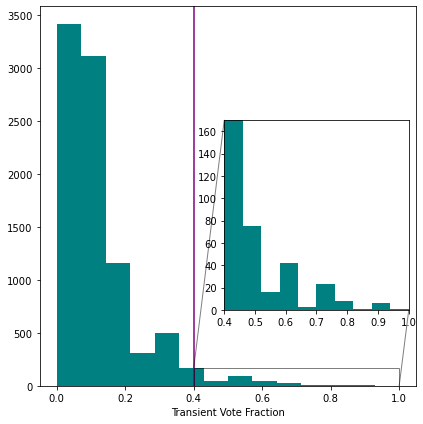

In [10]:
# a little histogram of the distribution of how many things got votes as a transient
# not used in the paper. This kind of power law makes sense. I inspected manually everything with T>0.4 
T=0.4
plt.figure(figsize=(6,6))
ax = plt.gca()
plt.hist(data['transFrac'], color = 'teal', bins =14)#
plt.axvline(T, color='purple')
plt.xlabel('Transient Vote Fraction')

#plt.yscale('log')

ax2 = ax.inset_axes([0.49,0.2,0.49,0.5])
ax2.hist(data[data['transFrac']>=0.4]['transFrac'], color = 'teal', bins =10)
ax2.set_xlim(0.4,1)
ax2.set_ylim(0,170)
ax.indicate_inset_zoom(ax2, edgecolor="black")
plt.tight_layout()
#plt.savefig('dist.png')
plt.show()

In [14]:
VDF = data[data['Known?'] == 1]

/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


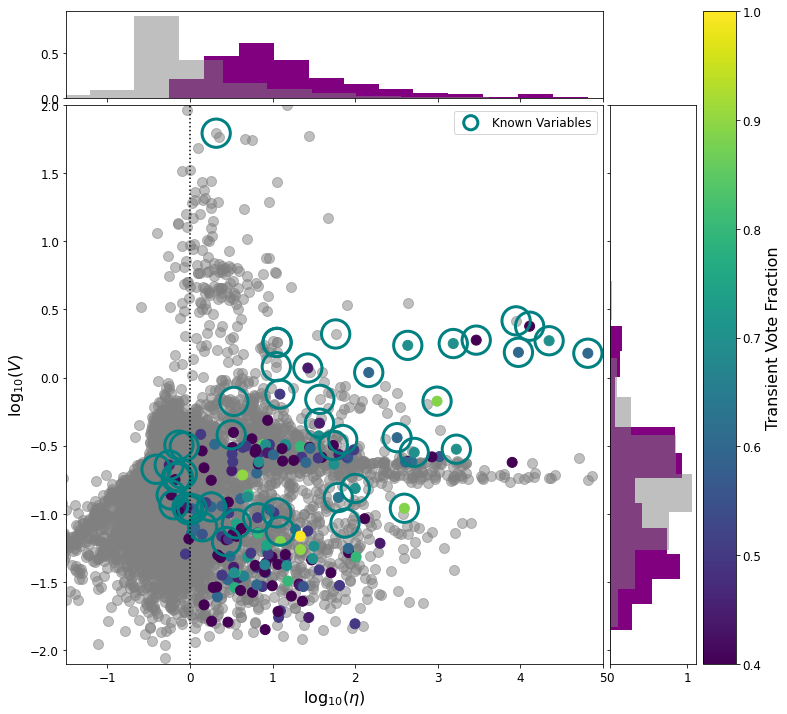

In [15]:
# The 'punchline' figure.
CitSciTs = data[data['t/v']==1]
Background = data[data['t/v']!=1]

plt.rc('axes', labelsize=16) 
plt.rc('xtick', labelsize=12)    
plt.rc('ytick', labelsize=12)


#eta V with marginal distribution
fig = plt.figure(figsize=(12,12))
ax=plt.gca()

plt.scatter(np.log10(Background.eta), np.log10(Background.V), c = "grey" , s = 100, alpha=0.5)
plt.scatter(np.log10(CitSciTs.eta), np.log10(CitSciTs.V), c = CitSciTs["transFrac"], cmap = "viridis" , s = 100)
plt.colorbar(pad = 0.01, fraction = 0.049).set_label('Transient Vote Fraction')

plt.scatter(np.log10(VDF.eta),np.log10(VDF.V), s=800,lw=3,facecolors='none', edgecolors='teal', label = 'Known Variables')
ax.axvline(x=0, color='black', ls=':') 


ax.set(xlabel = "log$_{10}(\eta)$", ylabel="log$_{10}(V)$", ylim=(-2.1,2), xlim=(-1.5,5))
#ax.set(xscale='log' , yscale ='log',xlabel = "$\eta$", ylabel="$V$", ylim=(0.01,100), xlim=(0.1,1e5))
ax.legend(markerscale=0.5, fontsize='large')

divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

'''
ax_histx.hist(CitSciTs.eta, bins = 10 ** np.linspace(np.log10(min(CitSciTs.eta+1)), np.log10(max(CitSciTs.eta+1)),50)-1,
              color='purple',density=True)

ax_histy.hist(CitSciTs.V,bins = 10 ** np.linspace(np.log10(1), np.log10(max(CitSciTs.V+1)),200)-1,
              orientation='horizontal', color='purple',density=True)
ax_histx.hist(Background.eta, bins = 10 ** np.linspace(np.log10(min(Background.eta+1)), np.log10(max(Background.eta+1)),500)-1,
              color='grey',alpha=0.5,density=True)
ax_histy.hist(Background.V, bins = 10 ** np.linspace(np.log10(1), np.log10(max(Background.V+1)),1000)-1,
              orientation='horizontal', color='grey',alpha=0.8,density=True)
              
              
'''
ax_histx.hist(np.log10(CitSciTs.eta), bins = 12,color='purple',density=True)
ax_histx.hist(np.nan_to_num(np.log10(Background.eta), neginf=0), bins = 20,color='grey',alpha=0.5,density=True)
ax_histy.hist(np.log10(CitSciTs.V),bins = 12, orientation='horizontal', color='purple',density=True)
ax_histy.hist(np.nan_to_num(np.log10(Background.V), neginf=0), bins = 20 , orientation='horizontal', color='grey',alpha=0.5,density=True)

ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

plt.savefig('etaV.pdf',bbox_inches='tight',transparent=False,facecolor='white')
plt.savefig('etaV.png',bbox_inches='tight',transparent=False,facecolor='white')

plt.show()

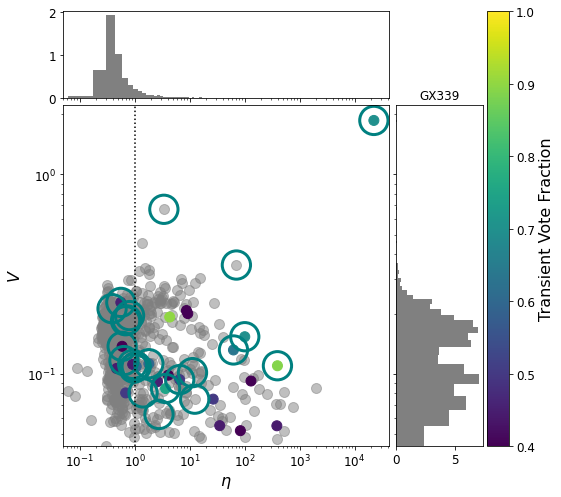

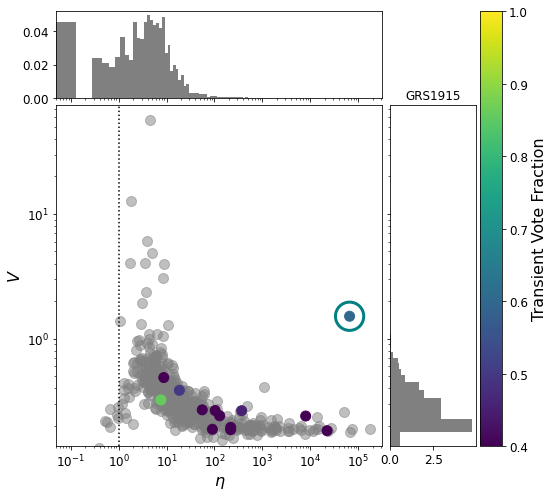

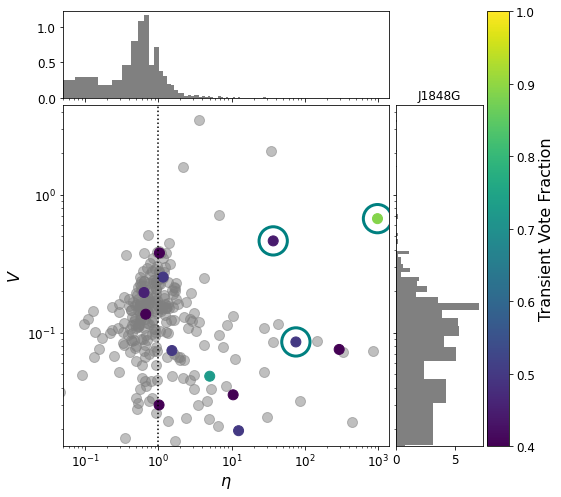

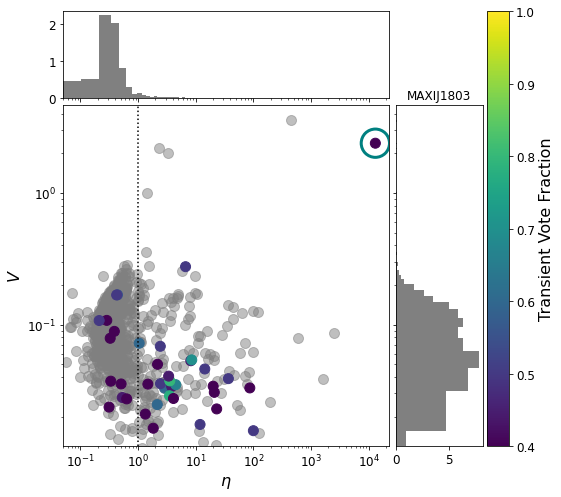

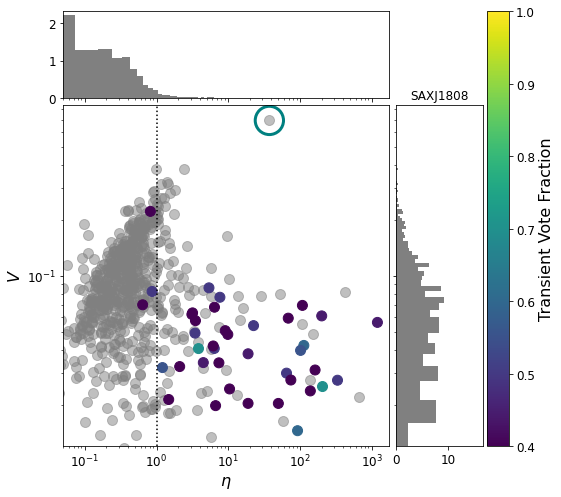

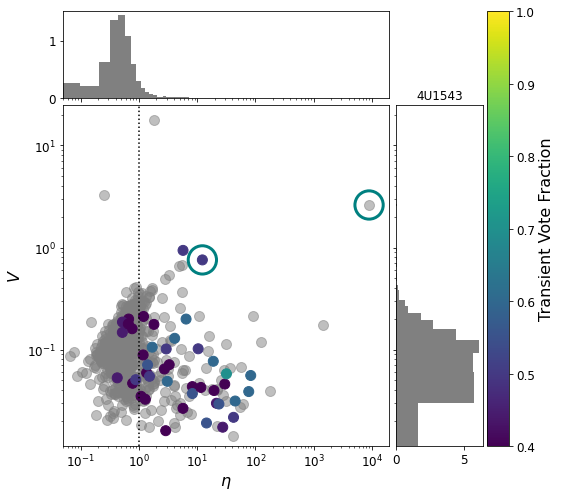

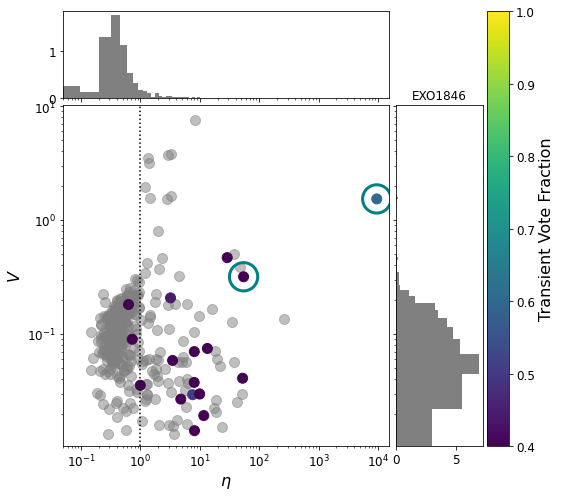

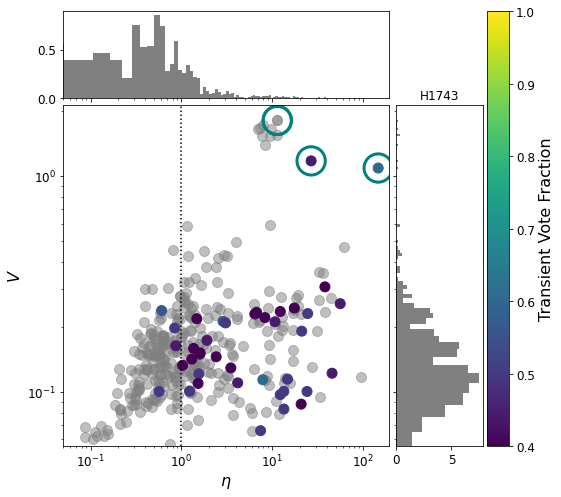

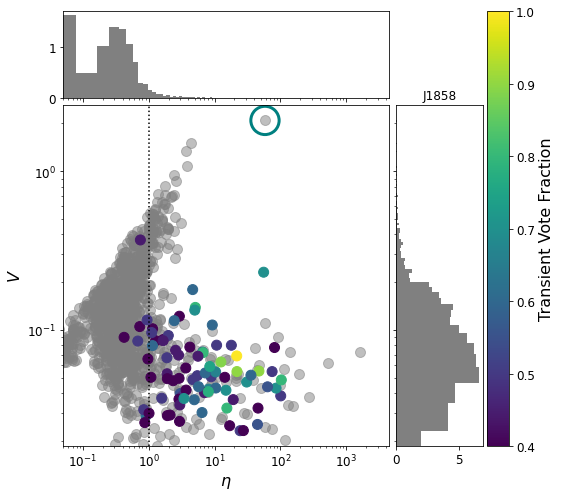

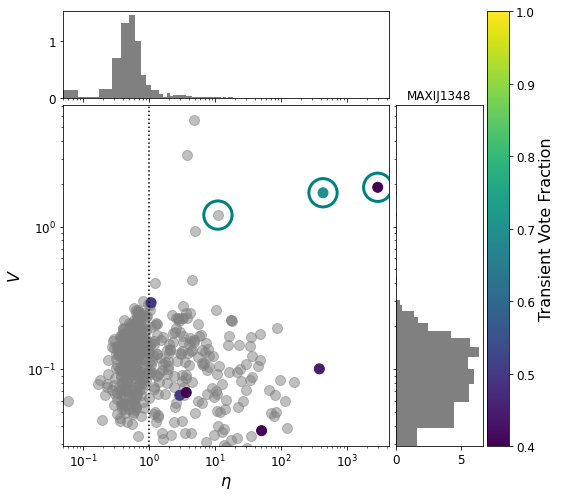

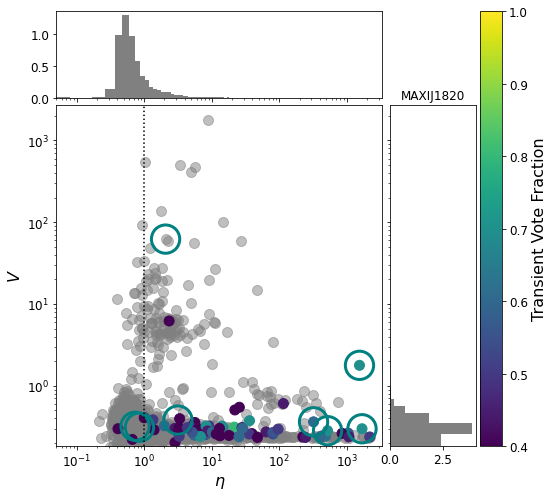

381 8493
381 8493


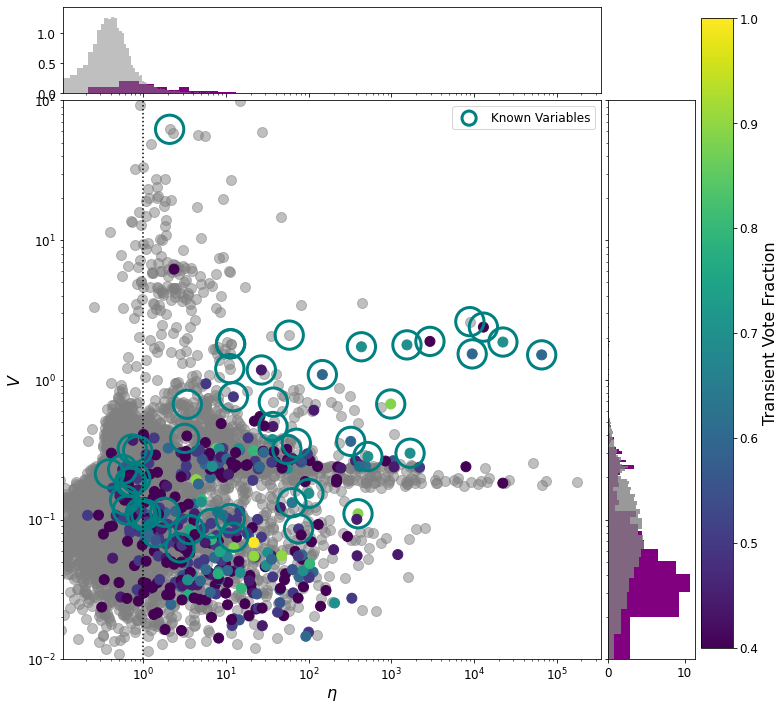

In [17]:
'''This is an old cell, basically like the above, but with splits per dataset and colorbar for vote fraciton again
Don't recommend using. However it does show us where our systematics are (mostly J1820 i think...)'''
"
T=0.4


t,f = 0,0
for field in data['Field'].unique():
    fieldData = data[data['Field'] == field]

    fieldT = fieldData[fieldData['transFrac']>=T]
    fieldF = fieldData[fieldData['transFrac']<T]
    t += len(fieldT)
    f += len(fieldF)
    
    Knowns = VDF[VDF['Field']==field]

    fig = plt.figure(figsize=(8,8))
    ax=plt.gca()
    plt.scatter(fieldF.eta, fieldF.V, c = "grey",alpha=0.5 , s = 100) #could also do a colour map?
    #plt.colorbar(pad = 0.01, fraction = 0.05).set_label('log10 Average Flux Density (mJy)')

    plt.scatter(fieldT.eta, fieldT.V, c = fieldT["transFrac"], cmap = "viridis" , s = 100,vmin=T,vmax=1.0)
    plt.colorbar(pad = 0.01, fraction = 0.05).set_label('Transient Vote Fraction')
    
    ax.scatter(Knowns.eta,Knowns.V, s=800,lw=3,facecolors='none', edgecolors='teal')
    
    ax.axvline(x=1, color='black', ls=':') 
    
    ax.set_xscale('log')
    ax.set_yscale('log')  
    ax.set_xlabel("$\eta$")
    ax.set_ylabel("$V$")
    ax.set_xlim(0.05)
    #ax.set_ylim(0.01)
    
    divider = make_axes_locatable(ax)
    # below height and pad are in inches
    ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
    ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

    ax_histx.hist(fieldData.eta, bins = 10 ** np.linspace(np.log10(min(fieldData.eta+1)), np.log10(max(fieldData.eta+1)),100)-1,
                  color='grey',density=True)
    ax_histy.hist(fieldData.V,   bins = 10 ** np.linspace(np.log10(1), np.log10(max(fieldData.V++1)),100)-1,
                  orientation='horizontal', color='grey',density=True)
    
    
    ax_histx.xaxis.set_tick_params(labelbottom=False)
    ax_histy.yaxis.set_tick_params(labelleft=False)
    plt.title(field)
    plt.show()

print(t,f)

MajorTrans = data[data['transFrac']>= T]
Background = data[data['transFrac'] < T]
print(len(MajorTrans),len(Background))

fig = plt.figure(figsize=(12,12))
ax=plt.gca()

plt.scatter(Background.eta, Background.V, c = "grey" , s = 100, alpha=0.5)
#plt.colorbar(pad = 0.01, fraction = 0.047).set_label('log10 Average Flux Density (mJy)')

plt.scatter(MajorTrans.eta, MajorTrans.V, c = MajorTrans["transFrac"], cmap = "viridis" , s = 100)
plt.colorbar(pad = 0.01, fraction = 0.047).set_label('Transient Vote Fraction')

plt.scatter(VDF.eta,VDF.V, s=800,lw=3,facecolors='none', edgecolors='teal', label = 'Known Variables')
    
ax.axvline(x=1, color='black', ls=':') 

ax.set(xscale='log' , yscale ='log',xlabel = "$\eta$", ylabel="$V$", ylim=(0.01,100))
ax.legend(markerscale=0.5, fontsize='large')

divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)


ax_histx.hist(MajorTrans.eta, bins = 10 ** np.linspace(np.log10(min(MajorTrans.eta+1)), np.log10(max(MajorTrans.eta+1)),50)-1,
              color='purple',density=True)
ax_histy.hist(MajorTrans.V,bins = 10 ** np.linspace(np.log10(1), np.log10(max(MajorTrans.V+1)),200)-1,
              orientation='horizontal', color='purple',density=True)
ax_histx.hist(Background.eta, bins = 10 ** np.linspace(np.log10(min(Background.eta+1)), np.log10(max(Background.eta+1)),500)-1,
              color='grey',alpha=0.5,density=True)
ax_histy.hist(Background.V, bins = 10 ** np.linspace(np.log10(1), np.log10(max(Background.V+1)),1000)-1,
              orientation='horizontal', color='grey',alpha=0.8,density=True)

ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

 
plt.show()

/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


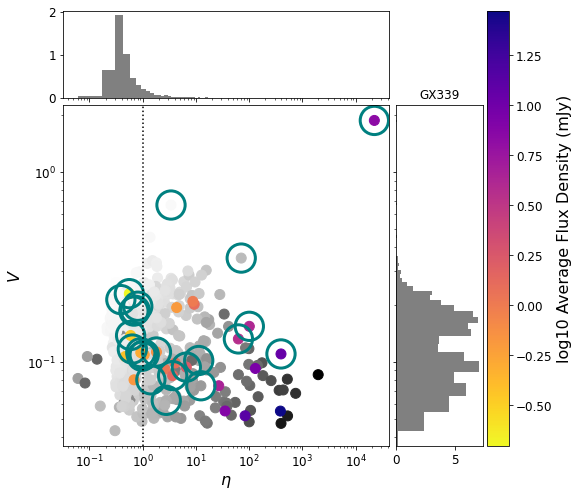

/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


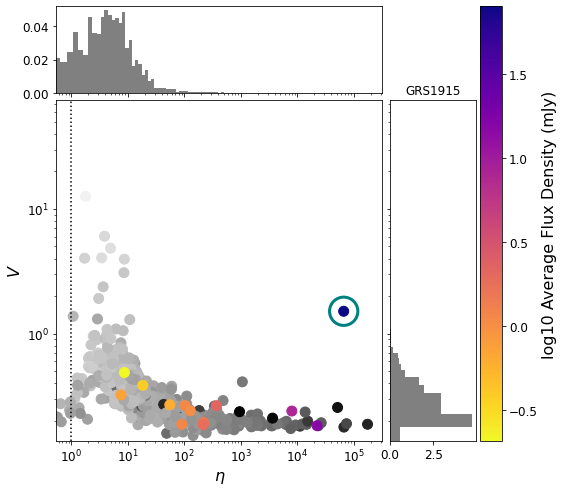

/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


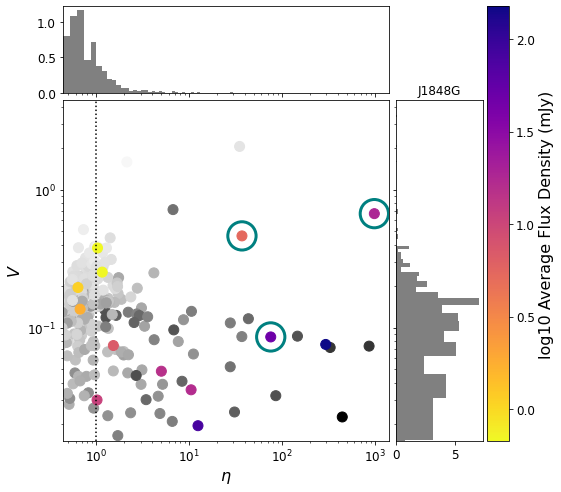

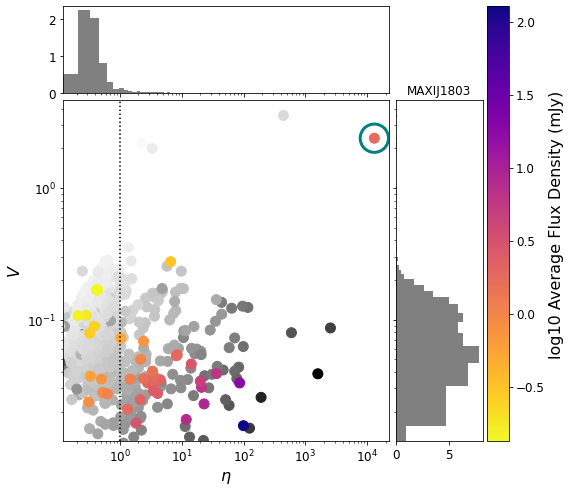

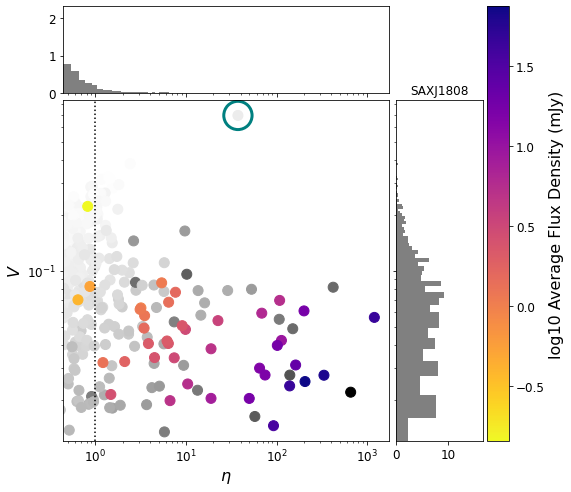

/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


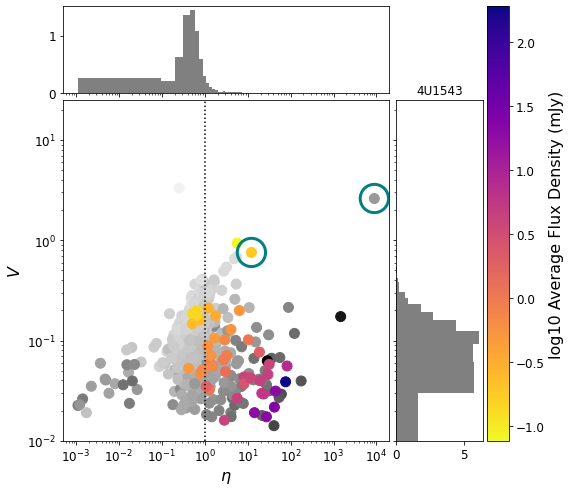

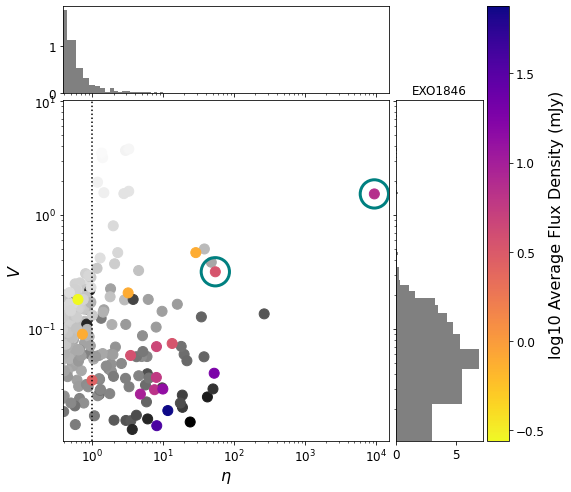

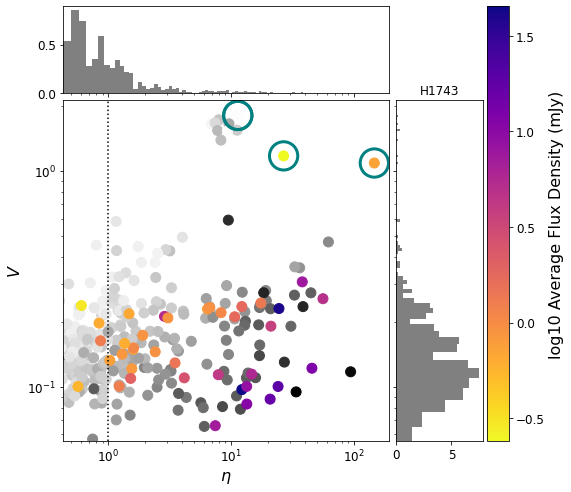

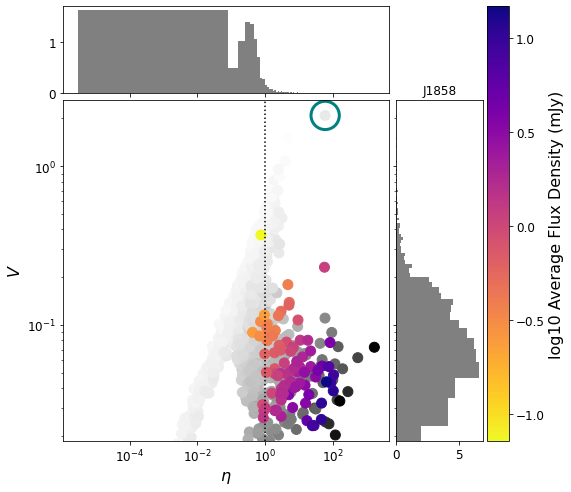

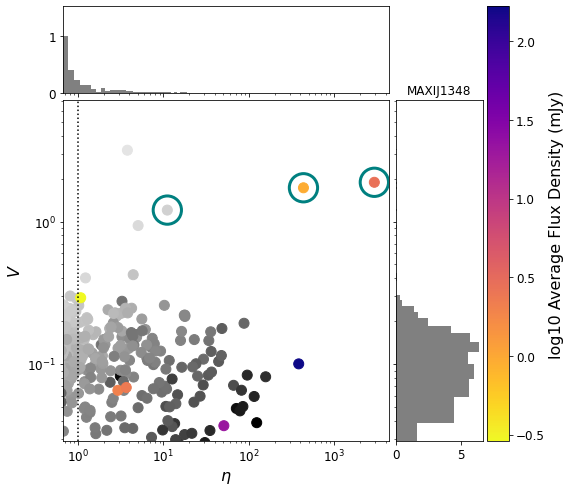

/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


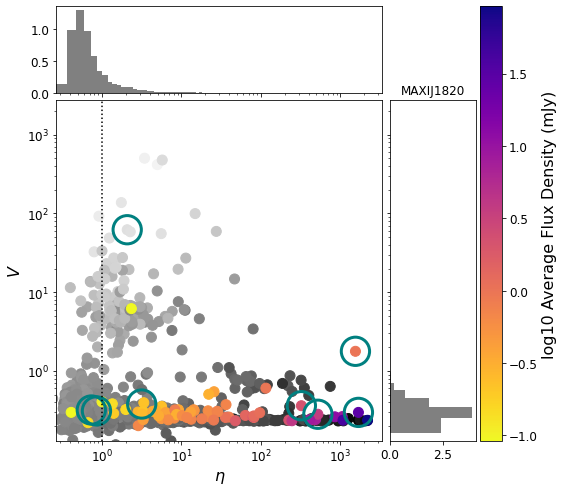

381 8493
381 8493


/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


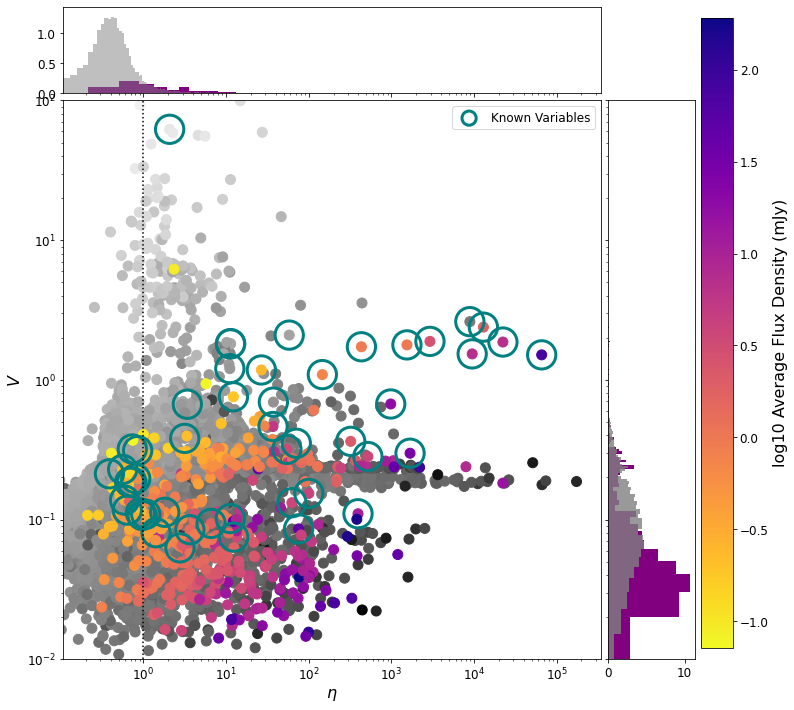

In [16]:
'''This is an old cell, basically like the above plot, but with colorbar for brightness. Don't recommend using.'''


T=0.4


t,f = 0,0
for field in data['Field'].unique():
    fieldData = data[data['Field'] == field]

    fieldT = fieldData[fieldData['transFrac']>=T]
    fieldF = fieldData[fieldData['transFrac']<T]
    t += len(fieldT)
    f += len(fieldF)
    
    Knowns = VDF[VDF['Field']==field]

    fig = plt.figure(figsize=(8,8))
    ax=plt.gca()
    plt.scatter(fieldF.eta, fieldF.V, c = np.log10(fieldF["avgFlux"]*1000), cmap = "Greys" , s = 100)
    #plt.colorbar(pad = 0.01, fraction = 0.05).set_label('log10 Average Flux Density (mJy)')

    plt.scatter(fieldT.eta, fieldT.V, c = np.log10(fieldT["avgFlux"]*1000), cmap = "plasma_r" , s = 100)
    plt.colorbar(pad = 0.01, fraction = 0.05).set_label('log10 Average Flux Density (mJy)')
    
    ax.scatter(Knowns.eta,Knowns.V, s=800,lw=3,facecolors='none', edgecolors='teal')
    
    ax.axvline(x=1, color='black', ls=':') 
    
    ax.set_xscale('log')
    ax.set_yscale('log')  
    ax.set_xlabel("$\eta$")
    ax.set_ylabel("$V$")
    #ax.set_xlim(min(fieldData.eta),max(fieldData.eta))
    #ax.set_ylim(min(fieldData.V),max(fieldData.V))
    
    divider = make_axes_locatable(ax)
    # below height and pad are in inches
    ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
    ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

    ax_histx.hist(fieldData.eta, bins = 10 ** np.linspace(np.log10(min(fieldData.eta+1)), np.log10(max(fieldData.eta+1)),100)-1,
                  color='grey',density=True)
    ax_histy.hist(fieldData.V,   bins = 10 ** np.linspace(np.log10(1), np.log10(max(fieldData.V++1)),100)-1,
                  orientation='horizontal', color='grey',density=True)
    
    
    ax_histx.xaxis.set_tick_params(labelbottom=False)
    ax_histy.yaxis.set_tick_params(labelleft=False)
    plt.title(field)
    plt.show()

print(t,f)

MajorTrans = data[data['transFrac']>= T]

Background = data[data['transFrac'] < T]
print(len(MajorTrans),len(Background))

fig = plt.figure(figsize=(12,12))
ax=plt.gca()

plt.scatter(Background.eta, Background.V, c = np.log10(Background["avgFlux"]*1000), cmap = "Greys" , s = 100)
#plt.colorbar(pad = 0.01, fraction = 0.047).set_label('log10 Average Flux Density (mJy)')

plt.scatter(MajorTrans.eta, MajorTrans.V, c = np.log10(MajorTrans["avgFlux"]*1000), cmap = "plasma_r" , s = 100)
plt.colorbar(pad = 0.01, fraction = 0.047).set_label('log10 Average Flux Density (mJy)')

plt.scatter(VDF.eta,VDF.V, s=800,lw=3,facecolors='none', edgecolors='teal', label = 'Known Variables')
    
ax.axvline(x=1, color='black', ls=':') 

ax.set(xscale='log' , yscale ='log',xlabel = "$\eta$", ylabel="$V$", ylim=(0.01,100))
ax.legend(markerscale=0.5, fontsize='large')

divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)


ax_histx.hist(MajorTrans.eta, bins = 10 ** np.linspace(np.log10(min(MajorTrans.eta+1)), np.log10(max(MajorTrans.eta+1)),50)-1,
              color='purple',density=True)
ax_histy.hist(MajorTrans.V,bins = 10 ** np.linspace(np.log10(1), np.log10(max(MajorTrans.V+1)),200)-1,
              orientation='horizontal', color='purple',density=True)
ax_histx.hist(Background.eta, bins = 10 ** np.linspace(np.log10(min(Background.eta+1)), np.log10(max(Background.eta+1)),500)-1,
              color='grey',alpha=0.5,density=True)
ax_histy.hist(Background.V, bins = 10 ** np.linspace(np.log10(1), np.log10(max(Background.V+1)),1000)-1,
              orientation='horizontal', color='grey',alpha=0.8,density=True)

ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

 
plt.show()

168
131 are consistent with scintillation
11 are just above scintillation - but we didnt test all model parameters exhaustively.


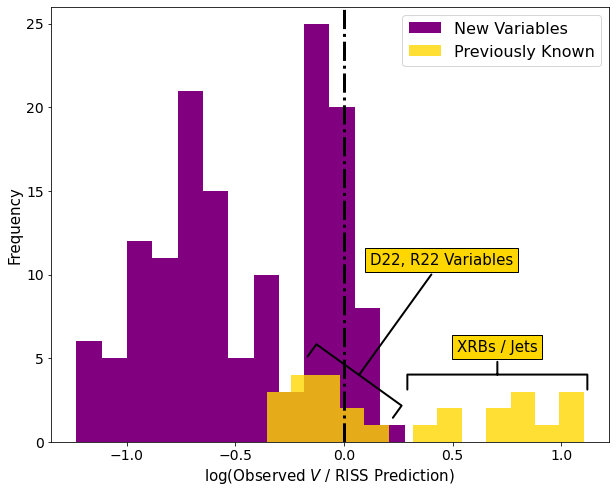

7.547818028606551 months
3.69706859854743 months


In [26]:
'Make a comparison between the Refractive InterStellar Scintillation model built into Hancock2019s code'
'and our observed V values from TraP'

RISS = pd.read_csv('RISSResults.csv')
CitSciTs = data[data['t/v']==1]
print(len(CitSciTs))


RISS=RISS.sort_values(by='RA')
CitSciTs = CitSciTs.sort_values(by='RA_y')

CitSciTs = pd.concat([CitSciTs.reset_index(), RISS.reset_index()], axis=1)
CitSciTs['ratio'] = CitSciTs['V']/CitSciTs['m']

recovered = CitSciTs[CitSciTs['Known?']==1]
others = CitSciTs[CitSciTs['Known?']==0]


print(len(others[others['ratio']<= 1]) , 'are consistent with scintillation')
print(len(others[others['ratio'] > 1]) , 'are just above scintillation - but we didnt test all model parameters exhaustively.')



plt.figure(figsize=(10,8))
plt.hist(np.log10(others['ratio']),bins=13, color = 'purple', label = 'New Variables')
plt.hist(np.log10(recovered.ratio),bins=13, alpha=0.8, color='gold', label = 'Previously Known')
plt.vlines(0,ymin=0,ymax=28, color = 'black', ls='-.', linewidth=3)

plt.gca().annotate('XRBs / Jets', xy=(0.8, 0.15), xytext=(0.8, 0.2), xycoords='axes fraction', 
            fontsize=15, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='gold'),
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=1', lw=2.0))

plt.gca().annotate('D22, R22 Variables', xy=(0.55, 0.15), xytext=(0.7, 0.4), xycoords='axes fraction', 
            fontsize=15, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='gold'),
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=1', lw=2.0))

plt.xlabel('log(Observed $V$ / RISS Prediction) ', fontsize=15)
plt.xticks(fontsize=14)
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)

plt.ylim(0,26)
#plt.savefig('RISSAnalysis.png', bbox_inches = 'tight', dpi=1000, transparent=False, facecolor='white')
#plt.savefig('RISSAnalysis.pdf', bbox_inches = 'tight', dpi=1000, transparent=False, facecolor='white')
plt.show()

'out of all the recovered T/Vs, the ones with ratio >1 are galactic xrbs, those with ratio < 1 are all Lauras LTVs'

'''using the RISS code, which gives a timescale of variation, to calculate typical timescale for our sample.
 We removed 3 outliers from the J1348 field which had HUGE Halpha values that skewed the data a lot'''
x = np.sort(others['t0'].values)[:-3]
x_err = np.sort(others['err_t0'].values)[:-3]
print(np.average(x, weights=x_err) * 12, 'months')
print(np.std(x)*12, 'months')

In [27]:
''' here is our estimate of variables and transients in the radio sky at this frequency and cadence. 
our sample of 168 out of the total number of sources is ~2%. We use the miss rate of known transients
 to estimate how many more variables there may be in our field. This is only valid if the recall of known transients
 and new variables is the same from our volunteers... which it sort of isnt.'''
KTs = 45 #known transients
TotalTs = KTs + len(others) #knowns + the others (i.e. not double counting the recovered ones)
missedF = (1 - len(recovered)/KTs)#this is what fraction of the knowns are not recovered, so a 'miss rate'
totalTF = TotalTs/len(data)
print(totalTF*100, '% of our sample are variable or transient')
print('But this could be as high as' , totalTF / missedF * 100,'%')

2.10727969348659 % of our sample are variable or transient
But this could be as high as 4.99092558983666 %
142


8039 168


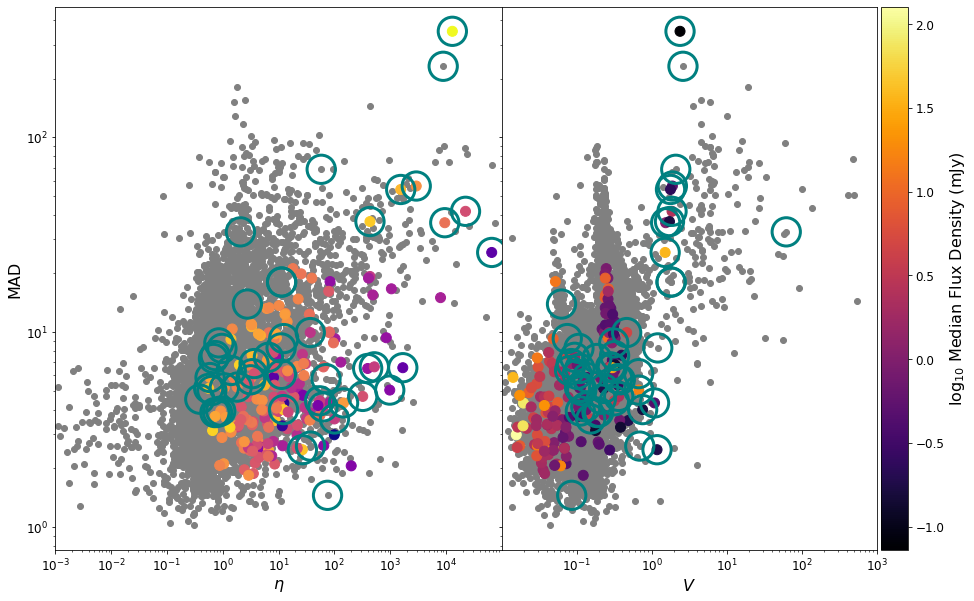

In [32]:
#compare eta and V to MAD (this is not in the paper as of current draft)       
Background = data[data['t/v']!=1]
CitSciTs = data[data['t/v']==1]


#must prune sources with 1dp, for which MAD doesnt compute:
Background = Background[Background['MAD']>1.000000001]
print(len(Background),len(CitSciTs))

c =np.log10(CitSciTs["medFlux"]*1000)
fig, axes = plt.subplots(1, 2, figsize=(16,10), sharey=True, squeeze=True)
fig.subplots_adjust(hspace=0,wspace=0)
ax1=axes[0]
ax2=axes[1]

ax1.scatter(Background['eta'],Background['MAD'],c='grey')
ax1.scatter(CitSciTs['eta'],CitSciTs['MAD'],c = c, cmap = "plasma_r" , s = 100)
ax1.scatter(VDF.eta,VDF.MAD, s=800,lw=3,facecolors='none', edgecolors='teal', label = 'Known Variables')
ax1.set(xscale='log' , yscale ='log',xlabel = '$\eta$', ylabel='MAD',xlim=(1e-2,1e5))

#prune overlapping labels in xaxis



#2nd subplot:
ax2.sharey(ax1)
ax2.scatter(Background['V'],Background['MAD'],c='grey')
plt1=ax2.scatter(CitSciTs['V'],CitSciTs['MAD'],c = c, cmap = "inferno" , s = 100)
ax2.scatter(VDF.V,VDF.MAD, s=800,lw=3,facecolors='none', edgecolors='teal', label = 'Known Variables')
ax2.set(xscale='log',xlabel = '$V$',xlim=(1e-2,1e2))

#prune overlapping labels in xaxis
T2=ax2.get_xticks()
ax2.set_xticks(T2[2:])
T1=ax1.get_xticks()
ax1.set_xticks(T1[:-2])

cbar = fig.colorbar(plt1, pad=0.01).set_label('log$_{10}$ Median Flux Density (mJy)')

plt.show()